RL system main four components \
(1) a policy \
(2) a reward function (the goal), what is good in an immediate sense \
(3) a value function (specifies what is good in the long run) \
(4) (optimally) a model of the environment

Five Sensors: Current, North, South, East, and West\
return the value of the respective location, where the possible values are Empty, Can, and Wall.

Five possible actions: \
Move-North, Move-South, Move-East, Move-West, & Pick-Up-Can. \
Note that we need to update the grid since when Robby picks up a can, the can is gone from the grid.

Reward: \
10 if Robby picks up a can.\
-5 if he crashes into a wall\
-1 if he tries to pick up a can in an empty square.

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt # plotting

# Create environment 
Zero means no can, one means can.
So after pick up a can, I should update the environment value to zero.

In [ ]:
# set up environment
def environment(grid):
  env = np.array([[np.random.randint(2) for i in range(grid)] for j in range(grid)], dtype = int)
  return env 

In [ ]:
# observe state with sensors      0: empty, 1: can, 2: wall
def sensorCurr(env, x, y):
  return env[x, y]
def sensorNorth(env, x, y):
  if y == 0:
    return 2
  return env[x, y-1]
def sensorSouth(env, x, y):
  if y == env.shape[1]-1: 
    return 2
  return env[x, y+1]
def sensorEast(env, x, y):
  if x == env.shape[0]-1:
    return 2
  return env[x+1, y]
def sensorWest(env, x, y):
  if x == 0:
    return 2
  return env[x-1, y]

# observe Robby's current state s_t
def observeState(env, x, y):
  state = (sensorCurr(env, x, y), sensorNorth(env, x, y), sensorSouth(env, x, y), sensorEast(env, x, y), sensorWest(env, x, y))
  return state

# epsilon greedy action selection
def epsilonGreedyActionSelection(env, epsilon, state):
  action_list = ['Pick-Up', 'North', 'South', 'East', 'West']

  # choose an action a_t, using epsilon greedy action selection
  if random.random() < epsilon: 
    # explore: select a random action (non-optimal/non-greedy action from the current state)
    action = random.choice(action_list)
    action_index = action_list.index(action)
  else: 
    # exploit: select the action with max value (future reward)
    action_index = np.argmax(Q[state])  
  return action_index

def getReward(x, y, env, action):
  reward = 0 # initial reward
  # perform the action
  if action == 4: # West
    if x == 0: # hit the wall
      reward = -5
    else: 
      x -= 1
  elif action == 3: # East
    if x == env.shape[0] - 1: # hit the wall
      reward = -5
    else:
      x += 1
  elif action == 2: # South
    if y == env.shape[1] - 1: # hit the wall
      reward = -5
    else:
      y += 1
  elif action == 1: # North
    if y == 0: # hit the wall
      reward = -5
    else:
      y -= 1
  else: # pick up can
      if env[x, y] == 0: # tries to pick up a can in an empty square
        reward = -1
      else:
        env[x, y] = 0
        reward = 10
  return x, y, reward

In [ ]:
def QLearning(N, M, Q, grid, epsilon, eta, gamma, decreasing_epsilon):
  total_reward_array = []
  total_reward = 0

  for episode in range(N):
    # generate a new distribution of cans and place Robby in a random grid square to start the new episode
    env = environment(grid)

    # Robby is initially places in a random grid square
    x = random.randint(0, grid-1)
    y = random.randint(0, grid-1)

    # update epsilon until epsilon would be zero
    if (episode % 50 == 0) and (decreasing_epsilon == True):
      if epsilon > 0:
        epsilon = epsilon - 0.005
      else:
        epsilon = 0

    for step in range(M):
      # observe state
      state = observeState(env, x, y)
      if state not in Q:
        Q[state] = np.zeros(5)
      
      # select action
      action = epsilonGreedyActionSelection(env, epsilon, state)

      # take action and receive reward
      new_x, new_y, reward = getReward(x, y, env, action)

      # receive reward r
      total_reward += reward

      # observe Robby's new state s_t+1
      new_state = observeState(env, new_x, new_y) 
      if new_state not in Q:
        Q[new_state] = np.zeros(5)

      # update Q(s,a) for training
      if decreasing_epsilon == True:
        Q[state][action] = Q[state][action] + eta * (reward + gamma * np.max(Q[new_state]) - Q[state][action])

      # update s_t <- s_t+1
      state = new_state
      x = new_x
      y = new_y

    # keep track of the total reward gained per episode (every 100 episodes)
    total_reward_array.append(total_reward)
    total_reward = 0
    
  return total_reward_array, Q

In [ ]:
grid = 10
state_size = grid * grid # 10 x 10 grid
action_size = 5 # NSEW+PickUpCan

# Initialize q-table values to 0
Q = {} 

N = 5000 # episode
M = 200 # steps(actions)
eta = 0.2 # learning rate
gamma = 0.9 # discount factor
epsilon = 0.1 # initial epsilon is 0.1 --> gradually decrease to 0

decreasing_epsilon = True
train_reward, train_Q = QLearning(N, M, Q, grid, epsilon, eta, gamma, decreasing_epsilon)

decreasing_epsilon = False
test_reward, test_Q = QLearning(N, M, train_Q, grid, epsilon, eta, gamma, decreasing_epsilon)

# Training Reward Plot & Test Reward Calculation (Average, Standard Deviation)

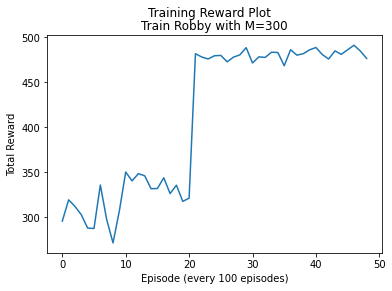

Test Average is:  458.6352
Test Standard Deviation is:  55.76667572089984


In [ ]:
total = 0
cumulative_train_reward = []
for i in range(len(train_reward)):
  total += train_reward[i]
  if i % 100 == 0 and i != 0:
    cumulative_train_reward.append(total/100)
    total = 0

plt.suptitle("Training Reward Plot" )
plt.title("Train Robby")
plt.plot(cumulative_train_reward) 
plt.ylabel('Total Reward', fontsize = 10)
plt.xlabel('Episode (every 100 episodes)', fontsize=10)
plt.show()

test_avg = np.mean(test_reward)
test_sd = np.std(test_reward)
print("Test Average is: ", test_avg)
print("Test Standard Deviation is: ", test_sd)